In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver, InMemorySaver
from langgraph.types import Command, interrupt

from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Annotated, Literal, List, Optional
from dotenv import load_dotenv, find_dotenv
from pydantic import BaseModel, Field
import operator
import json
import uuid

# Load environment
_ = load_dotenv(find_dotenv())

# -----------------------------
# Schemas (Pydantic)
# -----------------------------
class MangaFeatureSchema(BaseModel):
    main_characters: List[str] = Field(..., description="List of main characters in the story, including roles or names.")
    character_descriptions: List[str] = Field(..., description="Short descriptions of the characters’ traits, personalities, or roles.")
    setting: str = Field(..., description="The primary setting or environment where the story takes place.")
    conflict_or_goal: str = Field(..., description="The main conflict, tension, or goal driving the story.")
    important_objects: List[str] = Field(..., description="Key objects, weapons, or magical items relevant to the story.")
    mood_and_tone: List[str] = Field(..., description="Keywords describing the mood and tone of the story (normalized to lowercase).")
    key_sound_effects_and_emotions: List[str] = Field(..., description="Important sound effects (onomatopoeia) and strong emotions expressed in the story.")

class CharacterProfile(BaseModel):
    name_or_role: str
    canonical_name: Optional[str]
    age_range: str
    gender_presentation: Optional[str]
    body_type: str
    height: Optional[str]
    face: str
    hair: str
    eyes: str
    clothing: str
    accessories: List[str]
    color_palette: List[str]
    notable_marks: List[str]
    important_objects: List[str]
    signature_poses: List[str]
    default_expressions: List[str]
    voice_short: Optional[str]
    drawing_instructions: str
    visual_reference_prompt: str
    consistency_token: str

class CharacterList(BaseModel):
    characters: List[CharacterProfile] = Field(..., description="List of character profiles")

class SceneFeature(BaseModel):
    scene_number: int
    summary: str
    setting_details: str
    characters_involved: List[str]
    actions: List[str]
    emotions: List[str]
    potential_dialogues: List[str]
    inner_thoughts: List[str]
    sound_effects: List[str]
    visual_elements: List[str]

class SceneFeatureList(BaseModel):
    scenes: List[SceneFeature]

class Director_Panel(BaseModel):
    panel_number: int
    scene_description: str
    characters_present: List[str]
    actions: List[str]
    dialogues: List[str]
    inner_thoughts: List[str]
    sound_effects: List[str]
    visual_elements: List[str]

class MangaPage(BaseModel):
    page_number: int
    panels: List[Director_Panel]

class MangaImagePrompt(BaseModel):
    panel_number: int = Field(..., description="The panel number from the director script")
    image_prompt: str = Field(..., description="Short, clear description of what the image generation model should draw, including characters (with consistency_token), setting, action, emotions, camera angle, and sound effects")

class MangaImagePromptPage(BaseModel):
    page_number: int = Field(..., description="Page number in the manga")
    panel_prompts: List[MangaImagePrompt] = Field(..., description="List of image prompts corresponding to panels on this page")

class PanelAnalysis(BaseModel):
    panel_number: int = Field(..., description="Panel number being analyzed")
    quality_score: int = Field(..., ge=1, le=10, description="Quality score from 1-10, where 8+ is acceptable")
    issues: List[str] = Field(..., description="List of specific problems found in the prompt")
    strengths: List[str] = Field(..., description="List of good elements in the prompt")
    needs_improvement: bool = Field(..., description="Whether this panel needs improvement")
    suggested_fixes: List[str] = Field(..., description="Specific improvement suggestions")

class PromptAnalysisResult(BaseModel):
    panel_analyses: List[PanelAnalysis] = Field(..., description="Analysis for each panel")
    overall_score: float = Field(..., description="Average quality score across all panels")
    total_panels: int = Field(..., description="Total number of panels analyzed")
    panels_needing_improvement: int = Field(..., description="Count of panels that need improvement")
    needs_regeneration: bool = Field(..., description="Whether prompts should be regenerated")
    generation_attempt: int = Field(..., description="Current generation attempt number")
    max_attempts_reached: bool = Field(..., description="Whether maximum attempts have been reached")

# -----------------------------
# Model setup
# -----------------------------
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite")
structured_model_MangaFeature = model.with_structured_output(MangaFeatureSchema)
structured_model_characterList = model.with_structured_output(CharacterList)
structured_model_director = model.with_structured_output(MangaPage)
structured_model_scene = model.with_structured_output(SceneFeatureList)
structured_model_Mangaprompt = model.with_structured_output(MangaImagePromptPage)
structured_model_PromptAnalysis = model.with_structured_output(PromptAnalysisResult)

# -----------------------------
# Typed state
# -----------------------------
class MangaState(TypedDict):
    input_story: str
    refined_story: str
    reviewed_story: str
    extracted_features: dict
    character_feature: dict
    scene_features: dict
    panel_scenes: dict
    manga_image_prompts: dict
    prompt_analysis: dict
    generation_attempts: int
    max_attempts: int
   

# -----------------------------
# Node functions (prompt-heavy)
# -----------------------------

def prompt_refinner(state: MangaState):
    user_story = state['input_story']
    prompt = f"""
    Return only JSON. No explanation.

    Produce a refined manga-style story suitable for a ONE-PAGE comic.
    Requirements:
    - EXACTLY 4–6 short sentences. Each sentence should be usable as a panel idea.
    - Include manga elements: dramatic emotions, exaggerated reactions, inner thoughts in [brackets], and onomatopoeia.
    - Keep total length ~30–70 words.
    - If unable to follow, return {{ "error": "<reason>" }}.

    Output schema (exact):
    {{ "refined_story": "<string (4-6 sentences)>" }}

    Example output:
    {{ "refined_story": "He spots her across the courtyard and his heart *POW!* skips a beat. [She's an angel!] He trips rushing forward—*THUD!* She laughs, sunlight catching her smile. A silent promise forms in his chest." }}

    User Query: {user_story}
    """
    refine_output = model.invoke(prompt).content
    refine_output=refine_output.split("{")[1] if "{" in refine_output else refine_output
    refine_output="{"+refine_output.split("```")[0]
    print   ("Refine Prompt:", refine_output)
    print("Refine Output:", json.loads(refine_output))
    # store raw string under refined_story
    res=json.loads(refine_output)
    print("Refined Story:", res.get("refined_story",""))
    return {"refined_story": refine_output, "user_approved": False}


### ADDING HUMAN IN THE LOOP STEP HERE ###

def review_node(state: MangaState):
    # Ask a reviewer to edit the generated content
    updated = interrupt({
        "instruction": "Review and edit this content",
        "content": state["refined_story"],
    })
    return {"reviewed_story": updated}

def feature_extractor(state: MangaState):
    # Use user_edits if available, otherwise use refined_story
    refine_story = state.get("reviewed_story") or state["refined_story"]
    prompt = f"""
    Return only JSON. No explanation.

    Read the refined manga story and return fields exactly matching the MangaFeatureSchema below.
    Use empty lists [] or empty string "" when data is missing. Do NOT add extra keys.

    Schema (exact keys):
    {{
      "main_characters": ["string", ...],
      "character_descriptions": ["string", ...],
      "setting": "string",
      "conflict_or_goal": "string",
      "important_objects": ["string", ...],
      "mood_and_tone": ["keyword", ...],
      "key_sound_effects_and_emotions": ["string", ...]
    }}

    Example:
    {{
      "main_characters": ["Ibad", "Aisha"],
      "character_descriptions": ["shy, clumsy boy", "warm, smiling girl"],
      "setting": "school courtyard, midday",
      "conflict_or_goal": "Ibad must confess his feelings",
      "important_objects": ["schoolbag"],
      "mood_and_tone": ["romantic", "lighthearted"],
      "key_sound_effects_and_emotions": ["POW!", "THUD!", "embarrassment"]
    }}

    Refined Story:
    {refine_story}

    If you cannot produce valid JSON for any reason, return {{ "error": "<reason>" }}.
    """
    output = structured_model_MangaFeature.invoke(prompt)
    return {"extracted_features": output.model_dump()}


def character_makeup(state: MangaState):
    refined_story = state.get("reviewed_story") or state["refined_story"]
    extracted_feature = state.get('extracted_features')

    # Normalize extracted features
    if isinstance(extracted_feature, dict):
        extracted_feature_json = extracted_feature
    elif isinstance(extracted_feature, str):
        try:
            extracted_feature_json = json.loads(extracted_feature)
        except Exception:
            extracted_feature_json = {"main_characters": [], "character_descriptions": []}
    else:
        extracted_feature_json = {}

    prompt = f'''
        You are a manga character designer.
        Input: a short refined manga story and the extracted features (characters & brief descriptions).
        Your job: produce a JSON array "characters" of detailed, stable character profiles suitable for repeated drawing across multiple panels.
        You MUST output valid JSON ONLY and match the schema exactly.

        Schema (for each character):
        {{
        "name_or_role": "string",
        "canonical_name": "string or null",
        "age_range": "string",
        "gender_presentation": "string or null",
        "body_type": "string",
        "height": "string or null",
        "face": "short description (shape, nose, mouth, distinguishing facial features)",
        "hair": "short description (color, style, length)",
        "eyes": "short description (color, shape, special details like glow)",
        "clothing": "short description (top, bottom, shoes, texture)",
        "accessories": ["list of accessories"],
        "color_palette": ["primary", "secondary", "accent"],
        "notable_marks": ["scars, tattoos, birthmarks or empty list"],
        "important_objects": ["items associated with this character"],
        "signature_poses": ["list of 2-4 signature poses"],
        "default_expressions": ["list of 3 typical expressions used in manga"],
        "voice_short": "one-line descriptor of speaking voice or null",
        "drawing_instructions": "manga-specific tips (line weight, shading, preferred camera angles)",
        "visual_reference_prompt": "1-2 sentence prompt for an image generator to draw this character consistently",
        "consistency_token": "unique_short_token (use this in downstream image prompts to ensure consistency)"
        }}

        Rules:
        - You MUST create one character profile for every entry in "main_characters".
        - The number of profiles in "characters" must exactly equal the number of "main_characters".
        - Use the paired "character_descriptions" to enrich each profile.
        - If details are missing, infer them from the refined story.
        - Keep each profile short, clear, and usable for consistent drawing.
        - Output only valid JSON in the format: {{ "characters": [ ... ] }}

        Refined Story:
        {refined_story}

        Extracted Features:
        {json.dumps(extracted_feature_json)}

    '''
    output = structured_model_characterList.invoke(prompt)
    return {"character_feature": output.model_dump()}


def scene_feature_extractor(state: MangaState):
    refined_story = state.get("reviewed_story") or state["refined_story"]
    extracted_feature = state.get('extracted_features')
    characters = state.get('character_feature')

    # Normalize inputs
    if isinstance(extracted_feature, dict):
        features_json = extracted_feature
    else:
        try:
            features_json = json.loads(extracted_feature or "{}")
        except Exception:
            features_json = {}

    if isinstance(characters, dict):
        characters_json = characters
    else:
        try:
            characters_json = json.loads(characters or "{}")
        except Exception:
            characters_json = {}

    prompt = f"""
    You are a Manga Scene Director.
    Input: a refined short manga story, extracted features, and character profiles.
    Task: break the story into **4–5 sequential scenes** (not panels yet).
    These scenes will later guide panel creation.

    Output Schema (JSON only):
    {{
      "scenes": [
        {{
          "scene_number": 1,
          "summary": "1–2 sentence summary of what happens in this scene",
          "setting_details": "short description of location, mood, time",
          "characters_involved": ["names_or_roles"],
          "actions": ["list of short action phrases"],
          "emotions": ["keywords for emotional tone"],
          "potential_dialogues": ["list of possible dialogue lines (Name: text)"],
          "inner_thoughts": ["list of possible inner thoughts with [brackets]"],
          "sound_effects": ["list of onomatopoeia that could fit this scene"],
          "visual_elements": ["list of key visual cues, colors, lighting, objects, symbols"]
        }}
      ]
    }}

    Rules:
    - Always output 4 or 5 scenes. Never fewer.
    - Each scene should feel like it could become one manga panel later.
    - Use only characters from the character profiles.
    - Keep dialogues short, natural, manga-style.
    - Be consistent with story tone and features.
    - Return **valid JSON only**.

    Refined Story:
    {refined_story}

    Extracted Features:
    {json.dumps(features_json)}

    Character Profiles:
    {json.dumps(characters_json)}
    """

    output = structured_model_scene.invoke(prompt)
    return {"scene_features": output.model_dump()}


def manga_director(state: MangaState):
    refined_story = state.get("reviewed_story") or state["refined_story"]
    features = state.get('extracted_features')
    characters = state.get('character_feature')
    scenes = state.get('scene_features')

    prompt = f"""
    You are a Manga Director.
    Your job is to take the refined story, extracted features, character profiles,
    and pre-extracted scene features, and create a ONE-PAGE manga script divided into **exactly 4–5 panels**.

    Schema:
    {{
      "page_number": 1,
      "panels": [
        {{
          "panel_number": 1,
          "scene_description": "string (describe scene, setting, mood, camera angle)",
          "characters_present": ["list of character names_or_roles"],
          "actions": ["short action phrases"],
          "dialogues": ["Name: text"],
          "inner_thoughts": ["list of inner thoughts if any"],
          "sound_effects": ["list of onomatopoeia like BAM, WHOOSH"],
          "visual_elements": ["list of key visual cues, colors, lighting, objects, symbols"]
        }}
      ]
    }}

    Rules:
    - Output **exactly 4 or 5 panels**. Never fewer, never more.
    - Each panel should map to one of the extracted "scenes" (use `scene_reference` field).
    - Use only characters from the given profiles.
    - Keep dialogues short, natural, manga-style.
    - Balance between action, emotion, and pacing.
    - Ensure JSON output only, no extra explanation.

    Refined Story: {refined_story}

    Extracted Features: {features}

    Character Profiles: {characters}

    Scene Features: {scenes}
    """

    output = structured_model_director.invoke(prompt)

    # Enforce 4–5 panels (retry once with reminder if model returned wrong count)
    try:
        out_dict = output.model_dump()
    except Exception:
        out_dict = output

    panels = out_dict.get('panels') if isinstance(out_dict, dict) else None
    if panels is None or not (4 <= len(panels) <= 5):
        retry_prompt = prompt + "\n\nReminder: You must output 4–5 panels, not fewer, not more. Return only JSON."
        output = structured_model_director.invoke(retry_prompt)
        try:
            out_dict = output.model_dump()
        except Exception:
            out_dict = output

    return {"panel_scenes": out_dict}


def manga_comic_generator(state: MangaState):
    refined_story = state.get('user_edits') or state['refined_story']
    features = state.get("extracted_features")
    characters = state.get("character_feature")
    scenes = state.get("scene_features")
    panels = state.get("panel_scenes")

    prompt = f"""
    You are a black and white Manga Illustrator AI.
    Generate compact **manga-style comic panel prompts** (≤70 tokens each).

    # Rules:
    - Style: black-and-white manga, clean line art, screentone shading.
    - Characters: always use their "consistency_token" + short visual keywords.
    - Backgrounds: keep consistent, describe in ≤5 words.
    - Panel prompt must be **1 short sentence**, keyword-style.
    - Always include: camera angle, characters, action, scene, emotions, sound, dialogue.
    - End each with "in consistent manga style".

    # Inputs:
    Refined Story:
    {refined_story}

    Extracted Features:
    {json.dumps(features, indent=2)}

    Character Profiles (use consistency_token and visual_reference_prompt for each character):
    {json.dumps(characters, indent=2)}

    Scene Features:
    {json.dumps(scenes, indent=2)}

    Director’s Panel Script:
    {json.dumps(panels, indent=2)}

    # Output Instruction:
    For each panel in the Director’s Panel Script, generate an **image prompt** formatted as:

    {{
    "panel_number": <int>,
    "image_prompt": "<1–3 sentences describing exactly what to draw: include characters with their 'consistency_token' and full 'visual_reference_prompt', poses, expressions, actions, identical setting description, camera angle, sound effects, and dialogues/inner_thoughts. End with 'in consistent manga style'.>"
    }}

    Ensure:
    - Each panel’s "image_prompt" is fully self-contained (do not use 'as previously described').
    - Characters must always include their "consistency_token" and "visual_reference_prompt".
    - Backgrounds and clothing must always be described consistently in the same wording.
    - Include all dialogues and inner thoughts visually in the panel description.
    - Use sound effects from the panel if listed.
    - Only output valid JSON: a list of panel prompts.
    """

    output = structured_model_Mangaprompt.invoke(prompt)
    try:
        out_dict = output.model_dump()
    except Exception:
        out_dict = output
    return {"manga_image_prompts": out_dict}


def prompt_analyzer(state: MangaState):
    """
    Analyzes ALL manga image prompts collectively for overall page quality using Pydantic schemas.
    Returns structured analysis and decides whether to regenerate or proceed to END.
    """
    prompts_data = state.get("manga_image_prompts", {})
    panel_prompts = prompts_data.get("panel_prompts", [])
    attempts = state.get("generation_attempts", 0)
    max_attempts = state.get("max_attempts", 5)

    if not panel_prompts:
        empty_analysis = PromptAnalysisResult(
            panel_analyses=[],
            overall_score=0.0,
            total_panels=0,
            panels_needing_improvement=0,
            needs_regeneration=False,
            generation_attempt=attempts + 1,
            max_attempts_reached=attempts >= max_attempts
        )
        return {
            "prompt_analysis": empty_analysis.model_dump(),
            "generation_attempts": attempts + 1
        }

    all_prompts_text = "\n\n".join([
        f"Panel {panel.get('panel_number', i+1)}: {panel.get('image_prompt', '')}"
        for i, panel in enumerate(panel_prompts)
    ])

    collective_analysis_prompt = f"""
    You are an expert manga artist and prompt engineer for AI image generation.
    Analyze this COMPLETE MANGA PAGE (all panels together) according to professional manga standards:

    MANGA PAGE QUALITY CRITERIA:
    1. Character Consistency: Same consistency_tokens and visual descriptions across ALL panels
    2. Visual Continuity: Consistent backgrounds, clothing, props throughout the page
    3. Manga Style Elements: All panels mention screentone, line art, dramatic expressions
    4. Story Flow: Logical narrative progression from panel 1 to final panel
    5. Technical Quality: All panels end with "in consistent manga style"
    6. Emotional Arc: Clear emotional journey across the entire page
    7. Panel Cohesion: Panels work together as a unified comic page

    COMPLETE MANGA PAGE TO ANALYZE:
    {all_prompts_text}

    Analyze the ENTIRE PAGE and provide:
    - Individual panel analysis for each panel
    - Overall page quality assessment
    - Focus on consistency and flow between panels
    - Overall score should reflect page cohesion, not just individual panel quality
    """

    try:
        full_analysis = structured_model_PromptAnalysis.invoke(collective_analysis_prompt)
        analysis_result = full_analysis.model_dump()

        panel_analyses = analysis_result.get("panel_analyses", [])
        if len(panel_analyses) != len(panel_prompts):
            for i, panel in enumerate(panel_prompts):
                if i >= len(panel_analyses):
                    panel_num = panel.get("panel_number", i+1)
                    panel_analyses.append({
                        "panel_number": panel_num,
                        "quality_score": max(1, int(analysis_result.get("overall_score", 5))),
                        "issues": ["Needs consistency review"],
                        "strengths": ["Part of manga page"],
                        "needs_improvement": analysis_result.get("overall_score", 5) < 7.5,
                        "suggested_fixes": ["Improve consistency with other panels"]
                    })
        analysis_result["panel_analyses"] = panel_analyses

    except Exception as e:
        fallback_analyses = []
        for i, panel in enumerate(panel_prompts):
            panel_num = panel.get("panel_number", i+1)
            fallback_analyses.append({
                "panel_number": panel_num,
                "quality_score": 5,
                "issues": [f"Collective analysis failed: {str(e)[:50]}"],
                "strengths": ["Contains manga elements"],
                "needs_improvement": True,
                "suggested_fixes": ["Regenerate with better page consistency"]
            })
        analysis_result = {
            "panel_analyses": fallback_analyses,
            "overall_score": 5.0,
            "total_panels": len(panel_prompts),
            "panels_needing_improvement": len(panel_prompts),
            "needs_regeneration": attempts < max_attempts,
            "generation_attempt": attempts + 1,
            "max_attempts_reached": attempts >= max_attempts
        }

    overall_score = analysis_result.get("overall_score", 0)
    panels_needing_improvement = analysis_result.get("panels_needing_improvement", len(panel_prompts))

    page_quality_threshold = 7.5
    max_problematic_panels = 1

    should_regenerate = (
        (overall_score < page_quality_threshold or panels_needing_improvement > max_problematic_panels)
        and attempts < max_attempts
    )

    analysis_result["needs_regeneration"] = should_regenerate
    analysis_result["generation_attempt"] = attempts + 1
    analysis_result["max_attempts_reached"] = attempts >= max_attempts

    return {
        "prompt_analysis": analysis_result,
        "generation_attempts": attempts + 1
    }


def should_regenerate_prompts(state: MangaState):
    analysis = state.get("prompt_analysis", {})
    needs_regen = analysis.get("needs_regeneration", False)
    overall_score = analysis.get("overall_score", 0)
    max_attempts_reached = analysis.get("max_attempts_reached", False)

    if max_attempts_reached:
        return END
    elif needs_regen and overall_score < 9.5:
        return "manga_comic_generator"
    else:
        return END

# -----------------------------
# Graph wiring and runner
# -----------------------------

def build_workflow():
    graph = StateGraph(MangaState)
    graph.add_node("prompt_refinner",prompt_refinner)
    graph.add_node("review", review_node)
    graph.add_node("feature_extractor",feature_extractor)
    graph.add_node("character_makeup",character_makeup)
    graph.add_node("scene_feature_extractor", scene_feature_extractor) 
    graph.add_node("manga_director",manga_director)
    graph.add_node("manga_comic_generator",manga_comic_generator)
    # graph.add_node("prompt_analyzer", prompt_analyzer)

    #Creating Edges

    graph.add_edge(START,"prompt_refinner")
    graph.add_edge("prompt_refinner", "review")
    graph.add_edge("review", "feature_extractor")
    # graph.add_edge("feature_extractor", END)

    # graph.add_edge("review", "feature_extractor")
    graph.add_edge("feature_extractor","character_makeup")
    graph.add_edge("character_makeup","scene_feature_extractor")
    graph.add_edge("scene_feature_extractor","manga_director")
    graph.add_edge("manga_director","manga_comic_generator")
    #graph.add_edge("manga_comic_generator", "prompt_analyzer")
    graph.add_edge("manga_comic_generator", END)


    ### Addinf Persistent Human in the Loop Step Here ###
    checkpointer=InMemorySaver()
    workflow=graph.compile(checkpointer=checkpointer)
    return workflow


# if __name__ == "__main__":
#     workflow = build_workflow()

#     initial_state = {
#         'input_story': "A boy name Ibad fall in love with a girl named Aisha.",
#         'generation_attempts': 0,
#         'max_attempts': 1
#     }

#     final_state = workflow.invoke(initial_state)
#     print("Final state keys:", list(final_state.keys()))
#     # print analysis if present
#     try:
#         print("manga_image_prompts:\n", json.dumps(final_state.get('manga_image_prompts', {}), indent=2))
#     except Exception:
#         print("No prompt analysis available.")


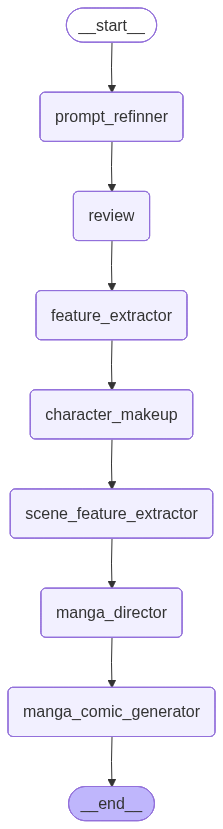

In [3]:
build_workflow()
workflow = build_workflow()
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [ ]:
import requests
import base64
from PIL import Image
from io import BytesIO

# Your running FastAPI diffusion server endpoint
server_url = "http://203.241.228.97:9000/generate"

def generate_image(prompt: str, server_url: str = server_url):
    """
    Sends a text prompt to a remote diffusion server and returns the generated image (in-memory).

    Args:
        prompt (str): Text description to send to the diffusion model.
        server_url (str): The URL of your diffusion server's API endpoint.

    Returns:
        PIL.Image.Image: The generated image.
    """
    try:
        # Send request to the diffusion server
        response = requests.post(server_url, json={"prompt": prompt})
        response.raise_for_status()

        data = response.json()
        if "image_base64" not in data:
            raise ValueError("No 'image_base64' field found in server response.")

        # Decode the base64 image
        image_data = base64.b64decode(data["image_base64"])
        image = Image.open(BytesIO(image_data))

        print("✅ Image generated successfully (in memory).")
        
        return image  # 👈 return the image instead of saving it

    except Exception as e:
        print(f"❌ Error generating image: {e}")
        raise



In [ ]:
from fastapi import FastAPI, HTTPException, BackgroundTasks
from fastapi.staticfiles import StaticFiles
from fastapi.responses import StreamingResponse
from pydantic import BaseModel
from typing import Optional, List, Dict, Any
import test_diffusion_v2
import pathlib
from io import BytesIO
from agent_basev2 import build_workflow
from langgraph.types import Command
import uuid
import base64
from fastapi.middleware.cors import CORSMiddleware
from fastapi.staticfiles import StaticFiles
import shutil


app = FastAPI(title="Auto-Manga - Manga Generator API")
# Add this block immediately after creating 'app'
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # Allows all origins (for development only)
    allow_credentials=True,
    allow_methods=["*"],  # Allows all methods (GET, POST, etc.)
    allow_headers=["*"],  # Allows all headers
)

# In-memory storage for workflow sessions
sessions = {}
# Serve generated images folder as public static files
app.mount(
    "/generated_images",
    StaticFiles(directory=r"C:\Users\Haider\Desktop\Manga\LangGraph\Manga_backend\auto-manga-react-app\src\generated_images"),
    name="generated_images"
)

class StoryInput(BaseModel):
    story: str

class StoryEdit(BaseModel):
    session_id: str
    edited_story: str

class SessionResponse(BaseModel):
    session_id: str
    generated_story: str
    status: str

class PanelPrompt(BaseModel):
    panel_number: int
    image_prompt: str
    image_path: Optional[str] = None

class PromptsResponse(BaseModel):
    session_id: str
    prompts: List[PanelPrompt]

class ImageResponse(BaseModel):
    panel_number: int
    image_base64: str

@app.post("/api/generate", response_model=SessionResponse)
async def generate_story(story_input: StoryInput):
    """
    Generate initial story from user input
    """
    

    shutil.rmtree(r"C:\Users\Haider\Desktop\Manga\LangGraph\Manga_backend\auto-manga-react-app\src\generated_images")

    if not story_input.story.strip():
        raise HTTPException(status_code=400, detail="Story cannot be empty")
    
    try:
    # if True:
        # Create unique session
        session_id = str(uuid.uuid4())
        config = {"configurable": {"thread_id": session_id}}
        
        # Build workflow
        workflow = build_workflow()
        
        # Run initial generation
        initial_state = {
            "input_story": story_input.story,
            "generation_attempts": 0,
            "max_attempts": 5
        }
        
        final_state = workflow.invoke(initial_state, config=config)
        
        generated_story = (
            final_state.get("reviewed_story")
            or final_state.get("refined_story")
            or ""
        )
        
        # Store session data
        sessions[session_id] = {
            "workflow": workflow,
            "config": config,
            "generated_story": generated_story,
            "final_state": final_state
        }
        
        return SessionResponse(
            session_id=session_id,
            generated_story=generated_story,
            status="success"
        )
    
    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Generation failed: {str(e)}")

import os
from io import BytesIO

@app.post("/api/approve", response_model=PromptsResponse)
async def approve_story(story_edit: StoryEdit):
    """
    Approve edited story, generate prompts, generate all images,
    store images in folder, and return public image URLs.
    """

    if story_edit.session_id not in sessions:
        raise HTTPException(status_code=404, detail="Session not found")
    
    try:
        session = sessions[story_edit.session_id]
        workflow = session["workflow"]
        config = session["config"]
        
        # Resume workflow with edited story
        final_after_review = workflow.invoke(
            Command(resume=story_edit.edited_story),
            config=config
        )
        
        # Extract panel prompts
        prompts_data = final_after_review.get("manga_image_prompts", {}).get("panel_prompts", [])
        
        if not prompts_data:
            raise HTTPException(status_code=500, detail="No prompts generated")

        # Folder where images will be saved
        base_folder = r"C:\Users\Haider\Desktop\Manga\LangGraph\Manga_backend\auto-manga-react-app\src\generated_images"
        session_folder = os.path.join(base_folder, story_edit.session_id)

        # Create session folder for images
        os.makedirs(session_folder, exist_ok=True)

        # Public URL prefix for images
        public_prefix = f"http://203.241.246.178:8000/generated_images/{story_edit.session_id}"

        updated_panels = []   # Final results list

        # Generate images for every panel
        for panel in prompts_data:
            panel_num = panel.get("panel_number")
            prompt_text = panel.get("image_prompt")

            # File naming
            file_name = f"panel_{panel_num}.png"
            local_path = os.path.join(session_folder, file_name)

            # Public URL returned to frontend
            public_url = f"{public_prefix}/{file_name}"

            try:
                # Generate and store image
                img = test_diffusion_v2.generate_image(prompt_text)
                img.save(local_path, format="PNG")

            except Exception as err:
                print(f"Error generating image for panel {panel_num}: {err}")

            # Save final result
            updated_panels.append(
                PanelPrompt(
                    panel_number=panel_num,
                    image_prompt=prompt_text,
                    image_path=public_url  # return PUBLIC url
                )
            )

        # Save in session
        session["prompts"] = updated_panels
        session["final_after_review"] = final_after_review

        # Return final response
        return PromptsResponse(
            session_id=story_edit.session_id,
            prompts=updated_panels
        )
    
    except HTTPException:
        raise
    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Approval failed: {str(e)}")



class PanelRegenerateRequest(BaseModel):
    session_id: str
    panel_number: int
    prompt: str
    refinements: Optional[str] = None

class PanelRegenerateResponse(BaseModel):
    panel_number: int
    image_path: str

@app.post("/api/regenerate-panel", response_model=PanelRegenerateResponse)
async def regenerate_panel(request: PanelRegenerateRequest):
    """
    Regenerate a specific panel with updated prompt and refinements
    """
    print(sessions)
    if request.session_id not in sessions:
        raise HTTPException(status_code=404, detail="Session not found")
    
    try:
        session = sessions[request.session_id]
        
        # Combine prompt with refinements if provided
        final_prompt = request.prompt
        if request.refinements and request.refinements.strip():
            final_prompt = f"{request.prompt}\n\nRefinements: {request.refinements}"
        
        # Folder where images will be saved
        base_folder = r"C:\Users\Haider\Desktop\Manga\LangGraph\Manga_backend\auto-manga-react-app\src\generated_images"
        session_folder = os.path.join(base_folder, request.session_id)
        
        # Create session folder if it doesn't exist
        os.makedirs(session_folder, exist_ok=True)
        



        
        # ------------------------
        # AUTO VERSIONING LOGIC
        # ------------------------
        base_name = f"panel_{request.panel_number}.png"
        
        # Find next available version
        version = 1
        file_name = base_name
        while os.path.exists(os.path.join(session_folder, file_name)):
            file_name = f"panel_{request.panel_number}_{version}.png"
            version += 1
        
        local_path = os.path.join(session_folder, file_name)
        
        # Generate image with the combined prompt
        img = test_diffusion_v2.generate_image(final_prompt)
        img.save(local_path, format="PNG")
        
        # Return public URL
        public_url = f"/generated_images/{request.session_id}/{file_name}"
        
        # Update session prompts if they exist
        if "prompts" in session:
            for panel in session["prompts"]:
                if panel.panel_number == request.panel_number:
                    panel.image_prompt = final_prompt
                    break
        
        return PanelRegenerateResponse(
            panel_number=request.panel_number,
            image_path=public_url
        )
    
    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Panel regeneration failed: {str(e)}")

@app.get("/api/session/{session_id}")
async def get_session(session_id: str):
    """
    Get session information
    """
    if session_id not in sessions:
        raise HTTPException(status_code=404, detail="Session not found")
    
    session = sessions[session_id]
    
    return {
        "session_id": session_id,
        "generated_story": session.get("generated_story", ""),
        "has_prompts": "prompts" in session,
        "num_prompts": len(session.get("prompts", []))
    }

@app.delete("/api/session/{session_id}")
async def delete_session(session_id: str):
    """
    Delete session and free up memory
    """
    if session_id not in sessions:
        raise HTTPException(status_code=404, detail="Session not found")
    
    del sessions[session_id]
    
    return {"status": "deleted", "session_id": session_id}

@app.get("/")
async def root():
    return {
        "message": "Manga Prompt Generator API",
        "endpoints": {
            "POST /api/generate": "Generate story from input",
            "POST /api/approve": "Approve edited story and get prompts",
            # "GET /api/image/{session_id}/{panel_number}": "Generate image (PNG)",
            # "GET /api/image-base64/{session_id}/{panel_number}": "Generate image (base64)",
            "GET /api/session/{session_id}": "Get session info",
            "DELETE /api/session/{session_id}": "Delete session"
        }
    }

if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)